In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN , Input,Flatten, LSTM
from tensorflow.keras import backend as K
from keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

In [5]:
opened = []

csv_path = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/'
masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_FINAL_REVISED.csv'

# Load the master list of stations
stations_df = pd.read_csv(masterlist)

# Extract station numbers, areas, and latitudes
station_num = stations_df['grdc_no']
station_area = stations_df['area']
station_lat = stations_df['lat']
station_slope = stations_df['average_slope']
# print(station_slope)
# Map station numbers to areas and latitudes
station_area_map = dict(zip(station_num, station_area))
station_lat_map = dict(zip(station_num, station_lat))
station_slope_map = dict(zip(station_num, station_slope))

# Generate the list of file paths
arrayFile = [os.path.join(csv_path, f"{station_no}.csv") for station_no in station_num]

# Initialize a list to store opened DataFrames
for file in arrayFile:
    station_no = os.path.basename(file).split('.')[0]  # Extract station number from the filename
    if os.path.exists(file):  # Check if file exists
        df = pd.read_csv(file, index_col=None, header=0)
        station_no_int = int(station_no)  # Convert station number to integer for lookup
        df['GRDC_No'] = station_no_int  # Add the station number as a new column
        df['Area'] = station_area_map.get(station_no_int, None)  # Add the Area column
        df['Latitude'] = station_lat_map.get(station_no_int, None)  # Add the latitude column
        df['Slope'] = station_slope_map.get(station_no_int, None)
        opened.append(df)

# Combine all DataFrames into one
total_df = pd.concat(opened, axis=0, ignore_index=True)

# Print or save the resulting DataFrame
print(total_df.head())


   Unnamed: 0     Date       Q       SWE   SWE_scaled  GRDC_No      Area  \
0           0  2018-08  24.526  2.087791  1809042.021  1159100  866486.0   
1           1  2018-09  31.372  1.835435  1590378.590  1159100  866486.0   
2           2  2018-10  19.572  1.976332  1712463.856  1159100  866486.0   
3           3  2018-11   7.349  1.633273  1415208.035  1159100  866486.0   
4           4  2018-12  13.824  1.782850  1544814.625  1159100  866486.0   

   Latitude      Slope  
0 -28.75799  46.796249  
1 -28.75799  46.796249  
2 -28.75799  46.796249  
3 -28.75799  46.796249  
4 -28.75799  46.796249  


In [6]:
landcover = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/ALL_STATIONS_LANDCOVER.csv'
landcover_df = pd.read_csv(landcover)

# Ensure number and GRDC_No are of the same type
total_df['GRDC_No'] = total_df['GRDC_No'].astype(int)
landcover_df['number'] = landcover_df['number'].astype(int)

# Initialize empty lists for new columns
new_columns = {col: [] for col in landcover_df.columns if col != 'number'}

# Loop through total_df and match with landcover_df
for grdc_no in total_df['GRDC_No']:
    match = landcover_df[landcover_df['number'] == grdc_no]
    
    if not match.empty:
        for col in new_columns:
            new_columns[col].append(match[col].values[0])  # Append matched value
    else:
        for col in new_columns:
            new_columns[col].append(None)  # Append NaN if no match found

# Convert lists to a DataFrame and concatenate with total_df
new_data = pd.DataFrame(new_columns)
total_df = pd.concat([total_df, new_data], axis=1)

print(total_df.head())

   Unnamed: 0     Date       Q       SWE   SWE_scaled  GRDC_No      Area  \
0           0  2018-08  24.526  2.087791  1809042.021  1159100  866486.0   
1           1  2018-09  31.372  1.835435  1590378.590  1159100  866486.0   
2           2  2018-10  19.572  1.976332  1712463.856  1159100  866486.0   
3           3  2018-11   7.349  1.633273  1415208.035  1159100  866486.0   
4           4  2018-12  13.824  1.782850  1544814.625  1159100  866486.0   

   Latitude      Slope         1  ...        11        12        13        14  \
0 -28.75799  46.796249  3.209576  ...  0.379222  0.354625  0.331737  0.327396   
1 -28.75799  46.796249  3.209576  ...  0.379222  0.354625  0.331737  0.327396   
2 -28.75799  46.796249  3.209576  ...  0.379222  0.354625  0.331737  0.327396   
3 -28.75799  46.796249  3.209576  ...  0.379222  0.354625  0.331737  0.327396   
4 -28.75799  46.796249  3.209576  ...  0.379222  0.354625  0.331737  0.327396   

         15      16        17        18   19  20  
0  0.

In [7]:
q = total_df['Q']
swe = total_df['SWE']
scaled = total_df['SWE_scaled']/100
area = total_df['Area']
station = total_df['GRDC_No']
lat = total_df['Latitude']
slope = total_df['Slope']

In [8]:
lc_types = total_df.iloc[:, -20:]
# print(lc_types)

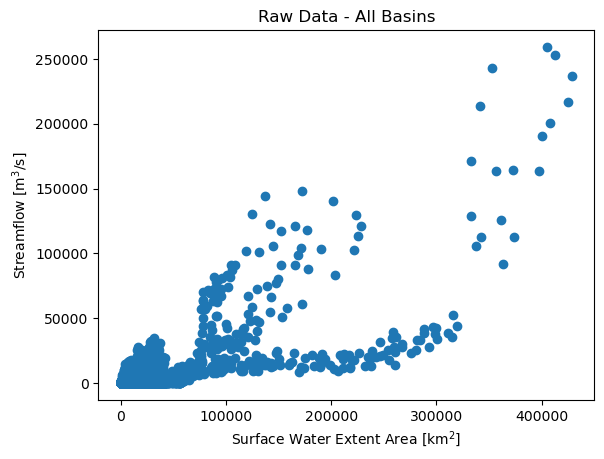

In [17]:
plt.scatter(scaled,q)
plt.title('Raw Data - All Basins')
plt.xlabel('Surface Water Extent Area [km${^2}$]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

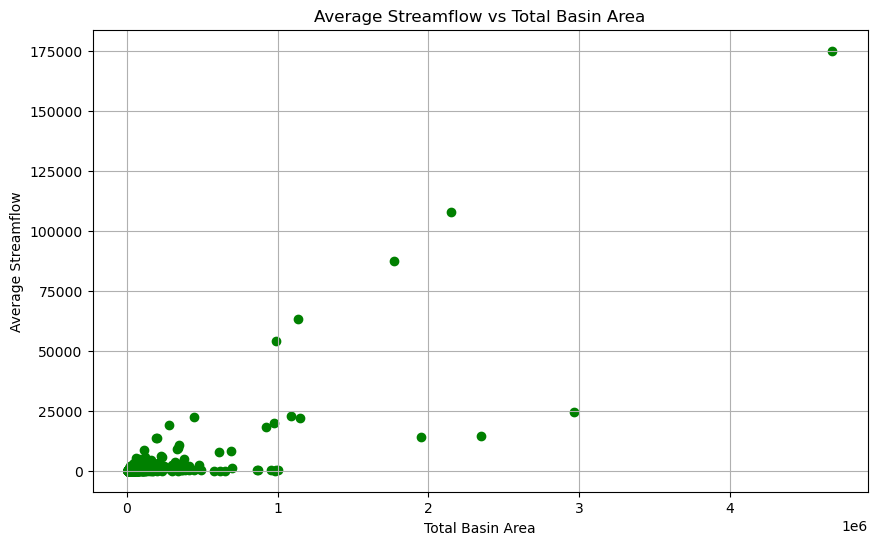

In [18]:
grouped = total_df.groupby('Area')['Q'].mean()

# Extract unique areas and their corresponding average Q values
area_unique = grouped.index
q_avg = grouped.values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(area_unique, q_avg, color='g')
plt.xlabel('Total Basin Area')
plt.ylabel('Average Streamflow')
plt.title('Average Streamflow vs Total Basin Area')
plt.grid(True)
plt.show()

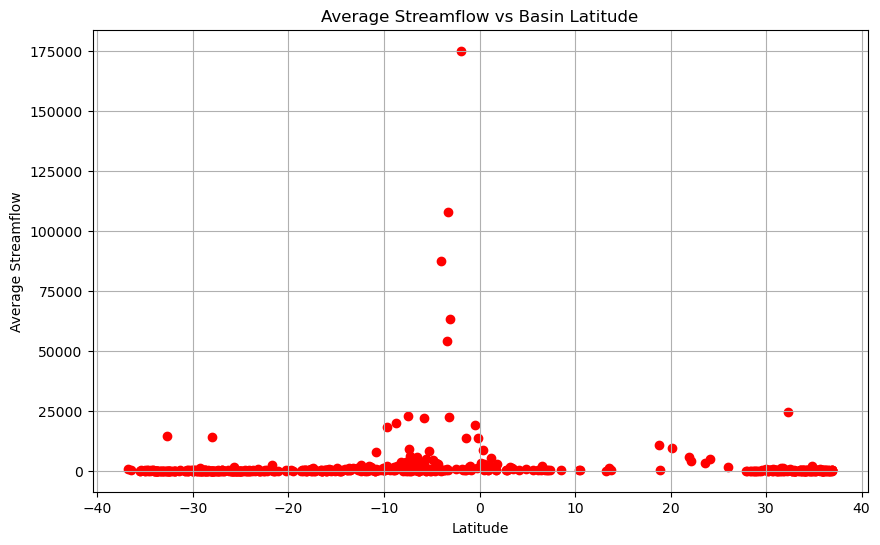

In [19]:
grouped = total_df.groupby('Latitude')['Q'].mean()

# Extract unique areas and their corresponding average Q values
lat_unique = grouped.index
q_avg = grouped.values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(lat_unique, q_avg,color='red')
plt.xlabel('Latitude')
plt.ylabel('Average Streamflow')
plt.title('Average Streamflow vs Basin Latitude')
plt.grid(True)
plt.show()

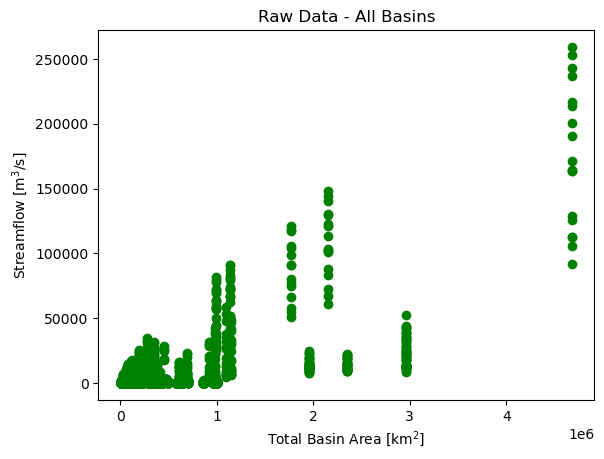

In [20]:
plt.scatter(area,q,color='g')
plt.title('Raw Data - All Basins')
plt.xlabel('Total Basin Area [km${^2}$]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

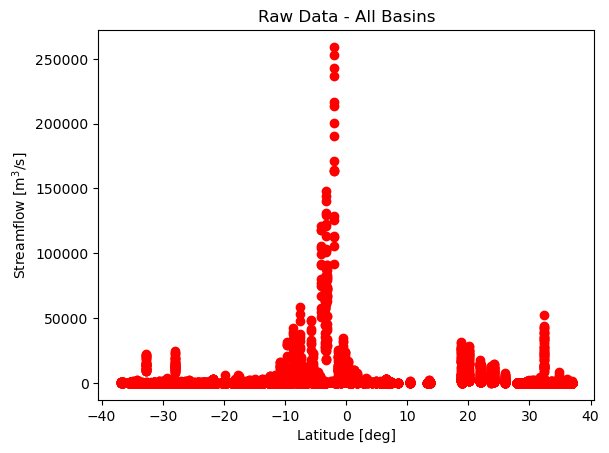

In [21]:
plt.scatter(lat,q,color='r')
plt.title('Raw Data - All Basins')
plt.xlabel('Latitude [deg]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

lat_in = (lat*np.pi)/180
# Convert q and swe to NumPy arrays
scaled_in = scaled.to_numpy()  # Assume scaled is a pandas Series
area_in = area.to_numpy()      # Assume area is a pandas Series
lat_in = lat.to_numpy()
slope_in = slope.to_numpy()
y = q.to_numpy()            # Target variable
lc_in = lc_types.to_numpy()

# # Convert q and swe to NumPy arrays
# scaled_in = scaled_in/max(scaled_in)  # Assume scaled is a pandas Series
# area_in = area_in/max(area_in)      # Assume area is a pandas Series
# lat_in = lat_in/max(lat_in)
# slope_in = slope_in/max(slope_in)
# y = y/max(y)            # Target variable
# lc_in = lc_in/np.max(lc_in)

# Step 1: Replace zeros with a small value
scaled_in[scaled_in == 0] = 1e-9
area_in[area_in == 0] = 1e-9
lat_in[lat_in == 0] = 1e-9
slope_in[slope_in == 0] = 1e-9
y[y == 0] = 1e-9


# Step 2: Combine features into a 2D array
X = np.column_stack((scaled_in, area_in, lat_in, slope_in, lc_in))  # Shape will be (num_samples, 2)
print(X[0])
# Step 3: Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

[ 1.80904202e+04  8.66486000e+05 -2.87579900e+01  4.67962488e+01
  3.20957644e+00  3.16560352e+01  9.31165861e+00  1.85908275e+00
  9.73310420e-01  7.33386343e-01  6.09938565e-01  5.14705544e-01
  4.43412315e-01  4.10527984e-01  3.79222101e-01  3.54624622e-01
  3.31737128e-01  3.27396396e-01  3.30816367e-01  3.90600080e-01
  4.21511351e-01  4.49857644e-02  0.00000000e+00  0.00000000e+00]


In [52]:
# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential([
    Dense(512, input_dim=24, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
from tensorflow.keras.optimizers import RMSprop, Nadam
from tensorflow.keras.losses import Huber
model.compile(optimizer=Nadam(learning_rate=1e-3), loss=Huber(delta=0.1), metrics=['mae'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,  # High epochs with early stopping
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/150


/global/home/users/arvalcarcel/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [54]:
# Step 7: Evaluate
test_loss = model.evaluate(X_test, y_test)
print(f"Test MAPE: {test_loss}")

# Step 8: Predict
predictions = model.predict(X_test)
y_pred = scaler_y.inverse_transform(predictions)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6893e-05 - mae: 0.0024
Test MAPE: [3.861884033540264e-05, 0.002184871584177017]
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


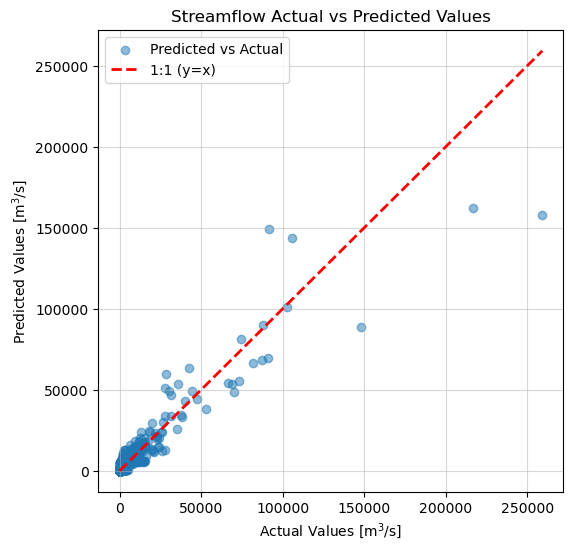

In [55]:
# Step 1: Predict values
y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend()
# plt.xlim(0,25000)
# plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

In [47]:
# # zoomed in plot
# y_pred = model.predict(X_test)
# # y_pred = np.expm1(y_pred)

# # Step 2: Create the scatter plot
# plt.figure(figsize=(6,6))
# plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)

# # Step 3: Add labels, title, and legend
# plt.title("Streamflow Actual vs Predicted Values")
# plt.xlabel("Actual Values [m${^3}$/s]")
# plt.ylabel("Predicted Values [m${^3}$/s]")
# plt.legend()
# plt.xlim(0,25000)
# plt.ylim(0,25000)
# plt.grid(alpha=0.5)

# # Step 4: Show the plot
# plt.show()

In [56]:
def nse(predictions, targets):
    return 1 - (np.sum((targets - predictions) ** 2) / np.sum((targets - np.mean(targets)) ** 2))

nse(y_pred, y_test)

0.8739570632288842

In [57]:
# Extract loss and validation loss from the training history
test_values = y_test*max(y)
pred_values = y_pred*max(y)

test_values = np.ravel(test_values)
pred_values = np.ravel(pred_values)

# Create a new DataFrame
pred_df = pd.DataFrame({
    'Test Values': test_values,
    'Predicted Values': pred_values
})

file_path =  '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/test_vs_pred_values.csv'

# Export to a CSV file
# pred_df.to_csv(file_path, index=False)

from sklearn.metrics import r2_score

# Assuming test_values and pred_values are 1D arrays or lists
r_squared = r2_score(test_values, pred_values)
print(f"R-squared value: {r_squared}")


R-squared value: 0.8739570660697287


Mean Squared Error (MSE): 9.374676731986751e-05


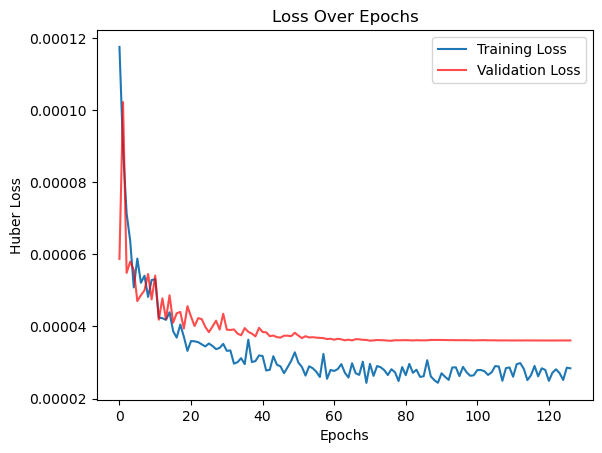

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Extract loss and validation loss from the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a new DataFrame
loss_df = pd.DataFrame({
    'Epoch': range(1, len(training_loss) + 1),  # Adding epoch numbers
    'Training Loss': training_loss,
    'Validation Loss': validation_loss
})

file_path =  '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/training_validation_losses.csv'

# Export to a CSV file
loss_df.to_csv(file_path, index=False)

# print((max(y_train) - min(y_train))**2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss',color='r',alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.title('Loss Over Epochs')
# plt.ylim(0.00001, 0.0002)
plt.legend()
plt.show()


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


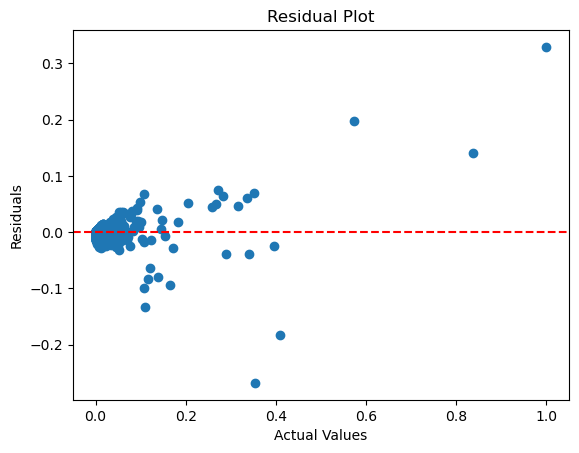

In [32]:
import matplotlib.pyplot as plt

residuals = y_test - model.predict(X_test)
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


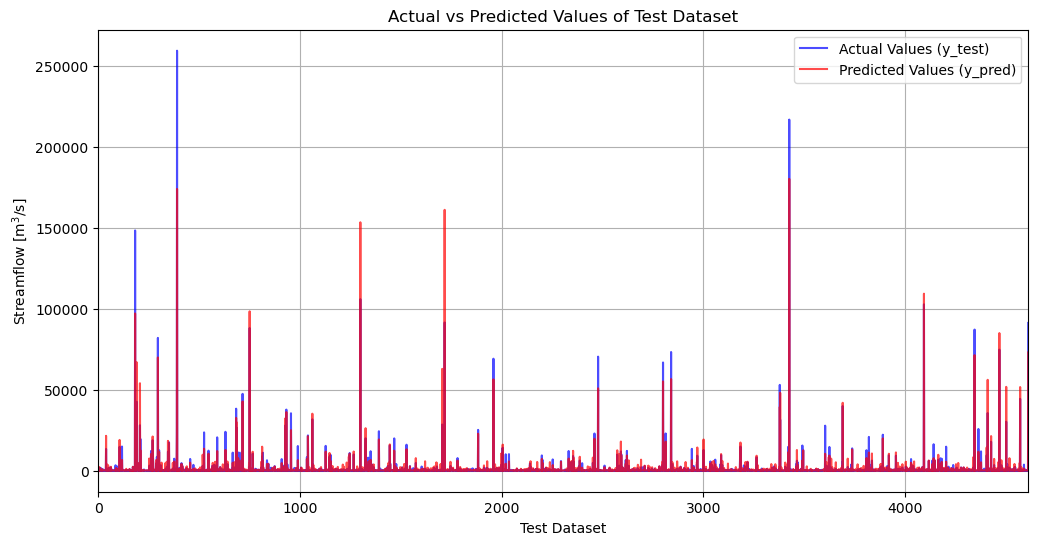

In [33]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test*max(y), label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot(np.arange(len(y_pred)), y_pred*max(y), label="Predicted Values (y_pred)", color="red", alpha=0.7)
plt.title("Actual vs Predicted Values of Test Dataset")
plt.xlabel("Test Dataset")
plt.ylabel("Streamflow [m${^3}$/s]")
plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

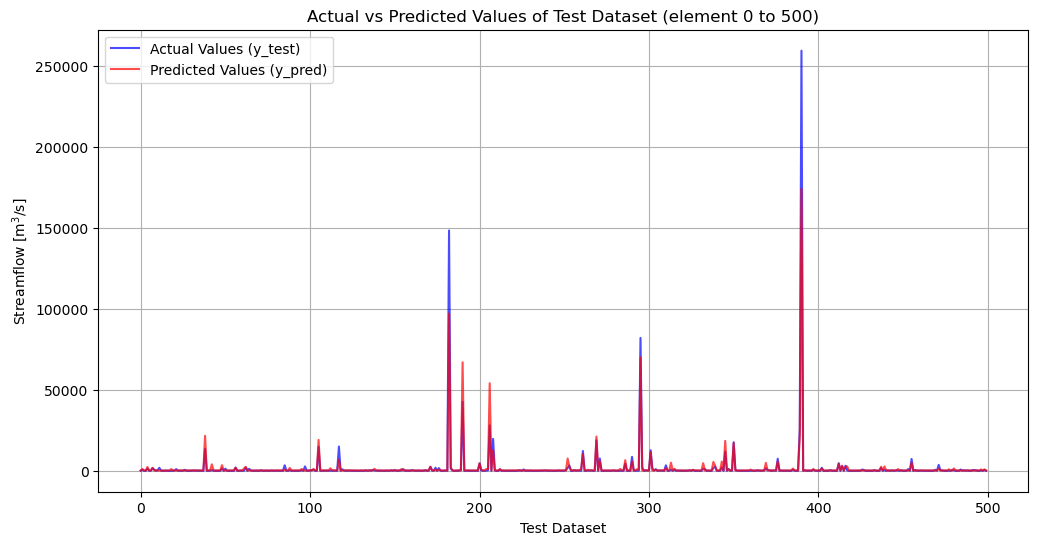

In [34]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot((np.arange(len(y_test)))[0:500], (y_test*max(y))[0:500], label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot((np.arange(len(y_pred)))[0:500], (y_pred*max(y))[0:500], label="Predicted Values (y_pred)", color="red", alpha=0.7)

# Add titles and labels
plt.title("Actual vs Predicted Values of Test Dataset (element 0 to 500)")
plt.xlabel("Test Dataset")
plt.ylabel("Streamflow [m${^3}$/s]")
# plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
filename = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rnn_plot.png'
# Ensure the directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)
from tensorflow.keras.utils import plot_model

# Plot and save the model
plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename)